In [1]:
%matplotlib inline
from pylab import *
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.ticker import AutoMinorLocator
matplotlib.rcParams.update({'font.size': 10})

matplotlib.rcParams['lines.linewidth'] = 0.5

matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.5

matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 1.5

In [20]:
print ('test')
def martians_year(ls, data):
    #### only looking at "second year"
    idx = np.where(ls==360)[0]
    if idx[0] != 0 and idx.size > 1:
        idx0 = idx[0]
        idx1 = idx[1]
        return data[idx0:idx1]
    elif idx[0] != 0 and idx.size == 1:
        idx1 = idx[0]
        return data[:idx1]
    elif idx[0] == 0:
        idx1 = idx[1]
        idx2 = idx[2]
        return data[idx1:idx2]

def martians_month(ls, data):
    temp = []
    for i in np.arange(0, 12):
        idx = np.where((ls>i*30)&(ls<(i+1)*30))[0]
        temp.append(data[idx].mean(axis=0))
    temp = np.array(temp)
    return temp

def zonal_plt_monthly(ydata, ls, data, title, level, norm, cmap):
    from matplotlib.colors import SymLogNorm
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,14))
    for i, ax in enumerate(axes.flat):
        y = ydata[i][6:]
        
        #press2 = zonal_p[i-1].mean(axis=1)
        lat = np.linspace(-90, 90, 36) 
        temp_press = np.linspace(1e-2, 900, ydata[i].shape[0])[6:]
        
        lat, temp_press = np.meshgrid(lat, temp_press)
        
        d = data[i][6:]

        if norm:
            im = ax.contourf(lat, y, d, levels=level, cmap=cmap, norm=SymLogNorm(linthresh=1e5,vmin=np.min(d), vmax=np.max(d)))
            if not np.isnan(d).any():
                ax.contour(lat, y, d, levels=level, linewidths=0.5, colors='k', norm=SymLogNorm(linthresh=1e5,vmin=np.min(d), vmax=np.max(d)))
                
            ax.xaxis.set_minor_locator(AutoMinorLocator(4))
        else: 
            im = ax.contourf(lat, y, d, levels=level, cmap=cmap, extend='both')
            if not np.isnan(d).any():
                ax.contour(lat, y, d, levels=level, linewidths=0.5, colors='k', extend='both')
        
        ax.set_title(r'{} LS {}-{}'.format((title), (i)*30, (i+1)*30))
        if i in [0,4,8]: ax.set_ylabel('Pressure [Pa]')
        if i in [8,9,10,11]: ax.set_xlabel('Latitude [$^\circ$]')
        ax.set_yscale('log')
        ax.set_ylim([900, 1e-2])
        
#        print ('Saving 1st cool shit')
    fig.tight_layout()
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, orientation='horizontal', pad=0.04)
    #plt.savefig(pdFfigures, format='pdf', bbox_inches='tight', dpi=400)

test


processing done!
(52, 36)


(900, 0.01)

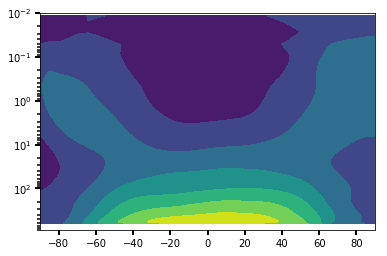

In [5]:
filedir = './../r14p1/'
ls = np.load(filedir + 'wrfout_LS.npy')

tfull = np.load(filedir + 'wrfout_ TFULL.npy')
tfull2 = np.load(filedir + 'wrfout_ TFULL2.npy')

pfull = np.load(filedir + 'wrfout_ PFULL.npy')
pfull2 = np.load(filedir + 'wrfout_ PFULL2.npy')

tfull = np.concatenate((tfull, tfull2), axis =0)
pfull = np.concatenate((pfull, pfull2), axis =0)
del tfull2, pfull2

tfull = martians_year(ls, tfull) [:5280]
pfull = martians_year(ls, pfull) [:5280]

tfull = tfull.reshape((12, 440, 52, 36, 72))
pfull = pfull.reshape((12, 440, 52, 36, 72))
pressure = pfull.mean(axis=4).mean(axis=1)
del pfull

print ('processing done!')
print (tfull[0].mean(axis=3).mean(axis=0).shape)

plt.contourf(np.linspace(-90,90,36), pressure[0].mean(axis=1), tfull[0].mean(axis=3).mean(axis=0))
plt.yscale('log')
plt.ylim([900,1e-2])

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [01:21<00:00,  6.74s/it]
C:\Users\visal\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:2761: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


(900, 0.01)

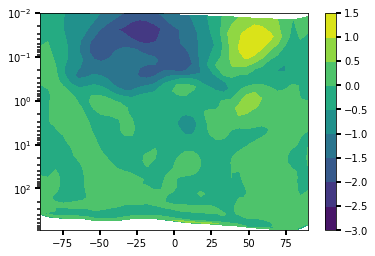

In [29]:
test_waven = 3
test_freq = 3

tmpPress = np.linspace(0,1,52)
lat = np.linspace(-90,90,36)
lat, press = np.meshgrid(lat, tmpPress)

filtered_array = []
for i in tqdm(np.arange(12)):
    press = pressure[i]

    tst = tfull[i]# - tfull[6].mean(axis=0)
    Tfft = (np.fft.fftshift(np.fft.ifft2(tst, axes=[0,3]), axes=[0,3]))#(4*np.pi)

    # sigma and s
    freq = np.fft.fftshift(np.fft.fftfreq(440, 180/1440.))
    waven = np.fft.fftshift(np.fft.fftfreq(72, 5.))*360 

    # find indexes where waven and period is a certain period
    idx_waven = np.where(waven==test_waven)[0] # positive wavenuber
    idx_period = np.where(abs(freq-test_freq)<.01)[0][0]  # positive frequency

    # picking the right components
    filtered = Tfft[idx_period,:,:,:][:,:,idx_waven]
    amp = filtered[:,:,0]
    filtered_array.append(amp)
filtered_array  = np.array(filtered_array)
#amp1 = amp#.mean(axis=0)

plt.contourf(lat, press, amp)
plt.colorbar()
plt.yscale('log')
plt.ylim([900,1e-2])

C:\Users\visal\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:2761: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


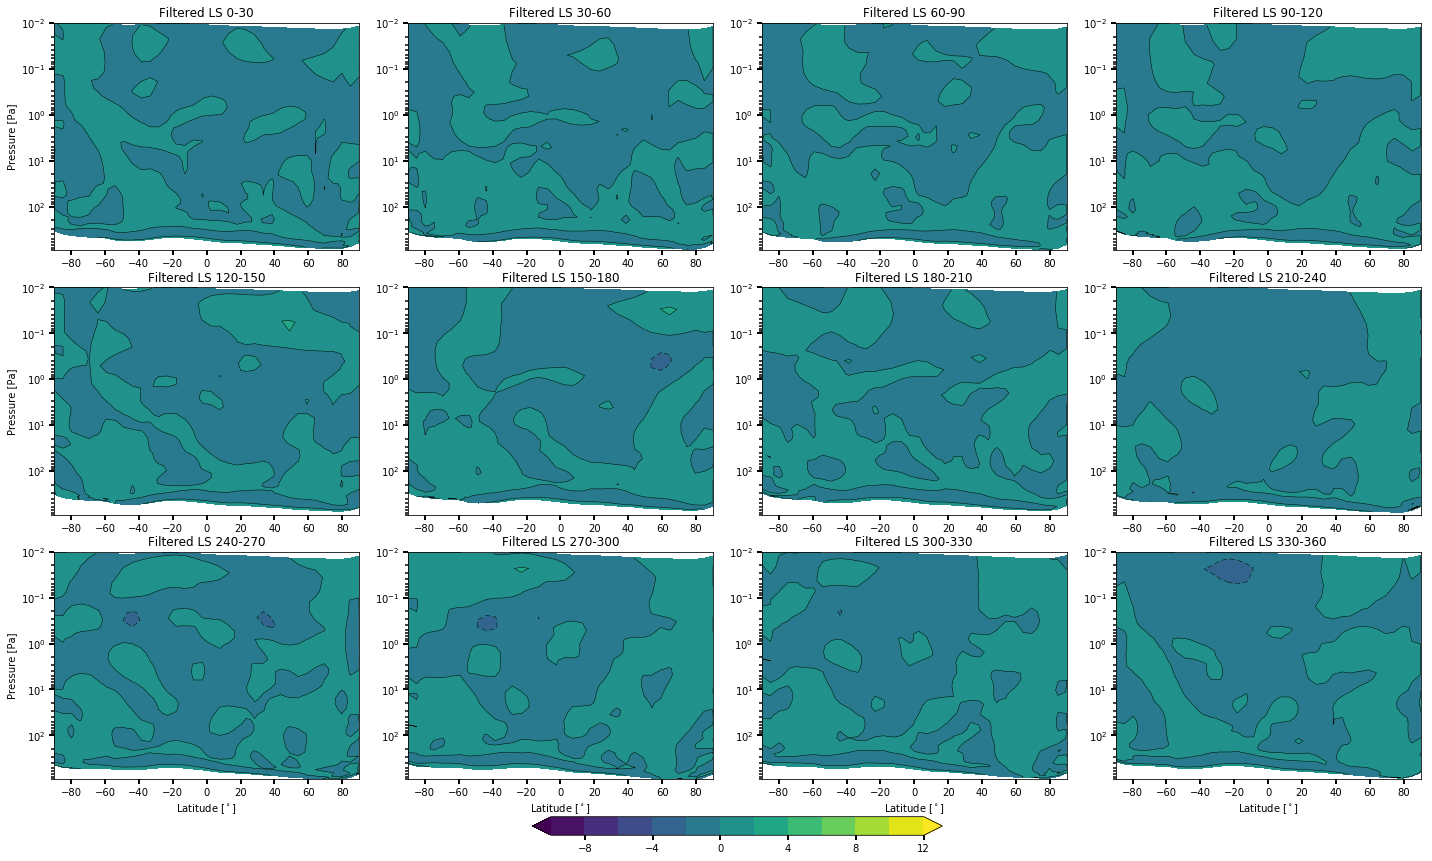

In [30]:
zonal_plt_monthly(pressure, ls, filtered_array, 'Filtered', np.linspace(-10,12, 12), False, 'viridis')

In [94]:
from dwell import fft
a,p,x,y=fft.spec(tst,1./8,1./72,axes=[0,3])


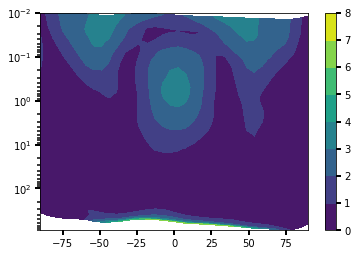

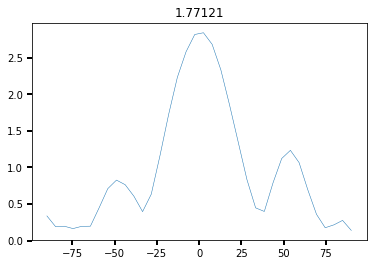

In [95]:
s=a*cos(p)
a1=a[abs(x+1)<0.1,:,:,y==1].mean(axis=0)
plt.contourf(lat, press, (a1))
plt.colorbar()
plt.yscale('log')
plt.ylim([900,1e-2])
figure()
plot(lat[40,:],a1[40,:]) ; title(press[40].mean())

C:\Users\visal\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:2761: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


(900, 0.01)

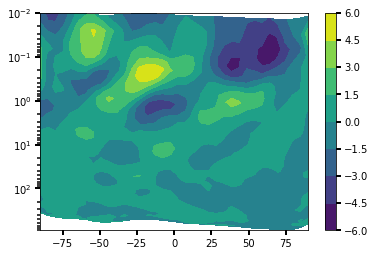

In [23]:
plt.contourf(lat, press, amp1+amp3)
plt.colorbar()
plt.yscale('log')
plt.ylim([900,1e-2])


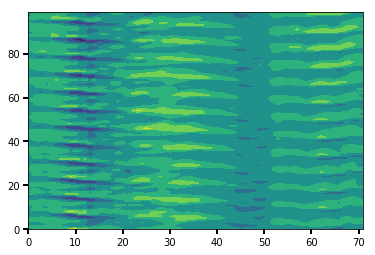

In [26]:
contourf(tfull[5][:100,29,18,:])